[Ver código de preprocesamiento de imágenes](#cd4251a9 "Celda de preprocesamiento de canales RGB")

In [1]:
! pip install optuna
! pip install scikit-learn
! pip install tensorflow
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install lime
! pip install seaborn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import make_blobs
from sklearn.preprocessing import RobustScaler, LabelBinarizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

c:\pinokio\bin\miniconda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
hamData = pd.read_csv("HAM10000_metadata.csv", sep=",")

hamData.head(5).T

,0,1,2,3,4
lesion_id,HAM_0000118,HAM_0000118,HAM_0002730,HAM_0002730,HAM_0001466
image_id,ISIC_0027419,ISIC_0025030,ISIC_0026769,ISIC_0025661,ISIC_0031633
dx,bkl,bkl,bkl,bkl,bkl
dx_type,histo,histo,histo,histo,histo
age,80.0,80.0,80.0,80.0,75.0
sex,male,male,male,male,male
localization,scalp,scalp,scalp,scalp,ear


In [4]:
hamData.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [5]:
hamData_encoded = pd.get_dummies(hamData, columns=['sex', 'localization'], drop_first=True)

hamData_encoded.T

,0,1,2,3,4,5,6,7,8,9,...,10005,10006,10007,10008,10009,10010,10011,10012,10013,10014
lesion_id,HAM_0000118,HAM_0000118,HAM_0002730,HAM_0002730,HAM_0001466,HAM_0001466,HAM_0002761,HAM_0002761,HAM_0005132,HAM_0005132,...,HAM_0005579,HAM_0004034,HAM_0001565,HAM_0001576,HAM_0005705,HAM_0002867,HAM_0002867,HAM_0002867,HAM_0000239,HAM_0003521
image_id,ISIC_0027419,ISIC_0025030,ISIC_0026769,ISIC_0025661,ISIC_0031633,ISIC_0027850,ISIC_0029176,ISIC_0029068,ISIC_0025837,ISIC_0025209,...,ISIC_0028393,ISIC_0024948,ISIC_0028619,ISIC_0033705,ISIC_0031430,ISIC_0033084,ISIC_0033550,ISIC_0033536,ISIC_0032854,ISIC_0032258
dx,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,bkl,...,akiec,akiec,akiec,akiec,akiec,akiec,akiec,akiec,akiec,mel
dx_type,histo,histo,histo,histo,histo,histo,histo,histo,histo,histo,...,histo,histo,histo,histo,histo,histo,histo,histo,histo,histo
age,80.0,80.0,80.0,80.0,75.0,75.0,60.0,60.0,70.0,70.0,...,80.0,55.0,60.0,60.0,75.0,40.0,40.0,40.0,80.0,70.0
sex_male,True,True,True,True,True,True,True,True,False,False,...,True,False,False,True,False,True,True,True,True,False
sex_unknown,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
localization_acral,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
localization_back,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
localization_chest,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
# Análisis de distribución de clases
class_distribution = hamData['dx'].value_counts()
print("Distribución de clases:")
print(class_distribution)
print("\nPorcentajes:")
print(class_distribution / len(hamData) * 100)
# Análisis por sexo
sex_distribution = hamData['sex'].value_counts()
print("\nDistribución por sexo:")
print(sex_distribution)
print("\nPorcentajes:")
print(sex_distribution / len(hamData) * 100)

Distribución de clases:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Porcentajes:
dx
nv       66.949576
mel      11.113330
bkl      10.973540
bcc       5.132302
akiec     3.265102
vasc      1.417873
df        1.148278
Name: count, dtype: float64

Distribución por sexo:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Porcentajes:
sex
male       53.979031
female     45.451822
unknown     0.569146
Name: count, dtype: float64


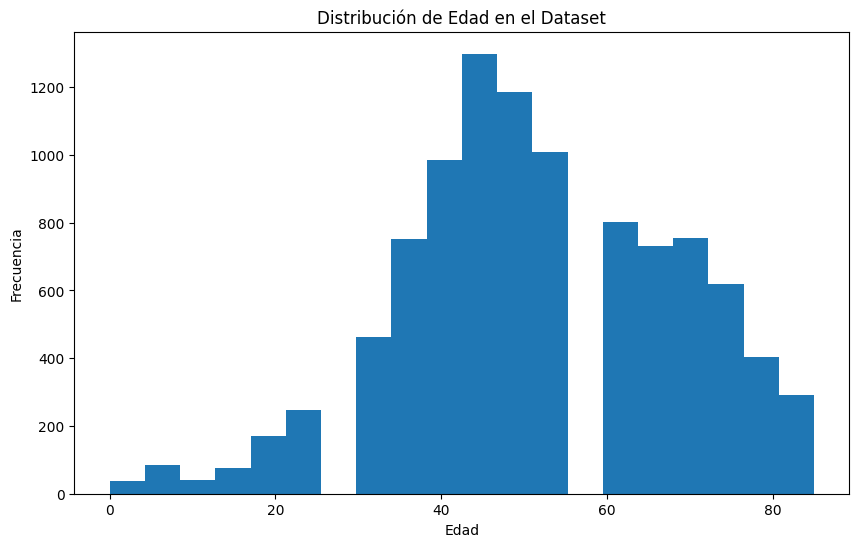

In [7]:
# Análisis por grupos de edad
plt.figure(figsize=(10,6))
plt.hist(hamData['age'], bins=20)
plt.title('Distribución de Edad en el Dataset')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

In [8]:
# Estratificación por múltiples variables
from sklearn.model_selection import StratifiedKFold

numeric_columns = hamData_encoded.select_dtypes(include=['float64', 'int64']).columns

# 3. Aplica la imputación solo a las columnas numéricas
hamData_encoded[numeric_columns] = hamData_encoded[numeric_columns].fillna(hamData_encoded[numeric_columns].median())

X = hamData_encoded.drop(['dx','image_id','lesion_id','dx_type'], axis=1).values
y = hamData_encoded['dx'].values

# hamData['strat'] = hamData['dx'] + '_' + hamData['sex'] + '_' + pd.qcut(hamData['age'], q=5).astype(str)
# x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=hamData['strat'])
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(x_train)
X_val_scaled = scaler.transform(x_val)


lb = LabelBinarizer()
y_train_encoded = lb.fit_transform(y_train)
y_val_encoded = lb.transform(y_val)

In [9]:
X_scaled = X_scaled.astype(float)
X_val_scaled = X_val_scaled.astype(float)

# Verificar si existen NaN o Inf en los datos de entrada y salida
if np.isnan(x_train.astype(float)).any():
    print("Se encontraron valores NaN en X_scaled")
elif np.isinf(x_train.astype(float)).any():
    print("Se encontraron valores Inf en X_scaled")
if np.isnan(y_val_encoded).any() or np.isinf(y_val_encoded).any():
    print("Se encontraron valores NaN o Inf en y_train")

print(f"Tamaño de y_train_encoded: {y_train_encoded.shape[0]}")
print(f"Tamaño de X_scaled: {X_scaled.shape[0]}")
print(f"Tamaño de y_val_encoded: {y_val_encoded.shape[0]}")
print(f"Tamaño de X_val_scaled: {X_val_scaled.shape[0]}")

Tamaño de y_train_encoded: 8012
Tamaño de X_scaled: 8012
Tamaño de y_val_encoded: 2003
Tamaño de X_val_scaled: 2003


In [56]:
def train_deep_net(activation_function, learning_rate, batch_size, num_epochs,lr_decay):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(100, activation=activation_function))  # Reducir unidades
  model.add(Dropout(0.5))
  model.add(Dense(50, activation=activation_function))
  model.add(Dense(y_train_encoded.shape[1], activation="softmax"))

  # Compilamos y entrenamos el modelo SGD
  print("[INFO]: Entrenando red neuronal...")
  opt = Adam(learning_rate=learning_rate, weight_decay=lr_decay)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  print(f"Tamaño de y_train_encoded: {y_train_encoded.shape[0]}")
  print(f"Tamaño de X_scaled: {X_scaled.shape[0]}")
  print(f"Tamaño de y_val_encoded: {y_val_encoded.shape[0]}")
  print(f"Tamaño de X_val_scaled: {X_val_scaled.shape[0]}")
  # Entrenando la solución
  H = model.fit(X_scaled, y_train_encoded, validation_data=(X_val_scaled, y_val_encoded), epochs=num_epochs, batch_size=batch_size)

  # Evaluando el modelo de predicción con las imágenes de test
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_val_scaled, batch_size=batch_size)
  print(classification_report(y_val_encoded.argmax(axis=1), predictions.argmax(axis=1)))

  # Muestro gráfica de accuracy y losses
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, num_epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  return model

[INFO]: Entrenando red neuronal...
Tamaño de y_train_encoded: 8012
Tamaño de X_scaled: 8012
Tamaño de y_val_encoded: 2003
Tamaño de X_val_scaled: 2003
Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5774 - loss: 1.3466 - val_accuracy: 0.6915 - val_loss: 0.9594
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6803 - loss: 0.9918 - val_accuracy: 0.6980 - val_loss: 0.9398
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6985 - loss: 0.9379 - val_accuracy: 0.6980 - val_loss: 0.9223
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7037 - loss: 0.9115 - val_accuracy: 0.6995 - val_loss: 0.9224
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7047 - loss: 0.9020 - val_accuracy: 0.6930 - val_loss: 0.9161
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7013 - loss: 0.9159 - val_accuracy: 0.6935 - val_loss: 0.9188
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7044 - loss: 0.

c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


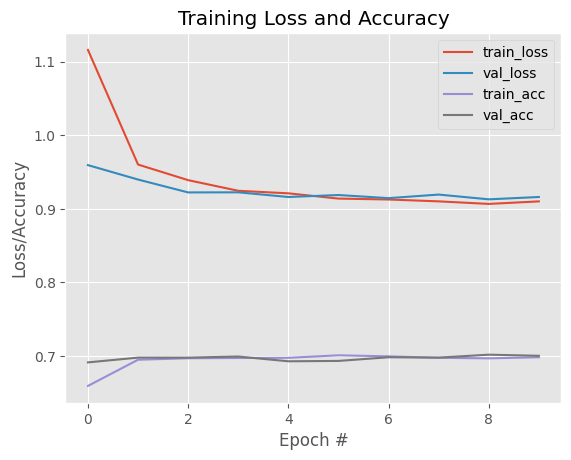

In [57]:
act = tf.nn.relu
learning_rate = 0.001
lr_decay = 1e-4
num_epochs = 10
batch_size = 32
model_tabular = train_deep_net(act, learning_rate, batch_size, num_epochs,lr_decay)

In [12]:
model_tabular.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 60)             │         6,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           217 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,423 (372.75 KB)

 Trainable params: 31,807 (124.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,616 (248.50 KB)

In [ ]:
def objective(trial):
    # Definir el espacio de búsqueda de parámetros
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh','sigmoid'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_epochs = trial.suggest_int('num_epochs', 5, 50, 100)

    # Construye el modelo
    model = Sequential()
    model.add(Dense(256, activation=activation_function, input_shape=(X_scaled.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation=activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation=activation_function))
    model.add(Dropout(0.5))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

    # Compila el modelo
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    # Entrena el modelo (usamos validación para evitar overfitting)
    history = model.fit(X_scaled, y_train_encoded,
                        validation_data=(X_val_scaled, y_val_encoded),
                        epochs=num_epochs,
                        batch_size=batch_size,
                        verbose=0)

    # Obtiene la precisión en el conjunto de validación
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy  # Maximize accuracy



In [14]:
# Crea una instancia de estudio de Optuna
study = optuna.create_study(direction='maximize', study_name="deep_learning_hyperparameter_optimization")

# Configura el número máximo de iteraciones (búsquedas)
n_trials = 20  # Puedes ajustar esto según tus recursos

# Ejecuta la búsqueda de hiperparámetros
study.optimize(objective, n_trials=n_trials)

# Resumen del estudio
print("Mejores parámetros encontrados:")
print(study.best_params)

print(f"Mejor precisión en validación: {100 * study.best_value:.2f}%")


[I 2025-04-24 11:21:32,292] A new study created in memory with name: deep_learning_hyperparameter_optimization
C:\Users\kage-\AppData\Local\Temp\ipykernel_25964\3386916745.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\kage-\AppData\Local\Temp\ipykernel_25964\3386916745.py:6: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_epochs = trial.suggest_int('num_epochs', 5, 50, 100)
c:\pinokio\bin\miniconda\lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [5, 50] and step=100, but the range is not divisible by `step`. It will be replaced by [5, 5].
  warnings.warn(
c:\pinokio\bin\miniconda\lib\site-packages\keras\src\layers\core\d

Mejores parámetros encontrados:
{'activation_function': 'sigmoid', 'learning_rate': 0.009618756000858644, 'batch_size': 64, 'num_epochs': 5}
Mejor precisión en validación: 69.80%


# Hito 2 Modelo 2D (imágenes):
### Resolver el problema considerando la información presente en las imágenes empleando para ello al menos una red convolucional.

In [15]:
hmnistData = pd.read_csv("hmnist_28_28_RGB.csv", sep=",")

hmnistData.head(5).T

,0,1,2,3,4
pixel0000,192,25,192,38,158
pixel0001,153,14,138,19,113
pixel0002,193,30,153,30,139
pixel0003,195,68,200,95,194
pixel0004,155,48,145,59,144
...,...,...,...,...,...
pixel2348,166,28,142,17,149
pixel2349,185,25,136,25,109
pixel2350,154,14,104,12,78
pixel2351,177,27,117,15,92


In [16]:
X = hmnistData.drop('label', axis=1).values
y = hmnistData['label'].values

# Dividir los datos en entrenamiento (80%) y prueba/validación (20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el conjunto de prueba/validación en prueba (10%) y validación (10%)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

unique_labels = hmnistData['label'].unique()

In [17]:
# Centramos los datos (le restamos la media)
X_train_mean = np.mean(X_train, axis=0)
X_train_cent = X_train - X_train_mean

# Normalizamos
X_train_std = np.std(X_train, axis=0)
X_train_norm = X_train_cent / X_train_std

X_test_norm = (X_test - X_train_mean) / X_train_std
X_val_norm = (X_val - X_train_mean) / X_train_std

# y_train_encoded = to_categorical(y_train_encoded, num_classes=len(unique_labels))
# y_val_encoded = to_categorical(y_val_encoded, num_classes=len(unique_labels))

In [18]:
print(f"Tamaño de X_train_norm: {X_train_norm.shape[0]}")
print(f"Tamaño de X_test_norm: {X_test_norm.shape[0]}")
print(f"Tamaño de X_val_norm: {X_val_norm.shape[0]}")

X_train_reshaped = X_train_norm.reshape(-1, 28, 28, 3)  # Ajusta estos valores si es necesario
X_test_reshaped = X_test_norm.reshape(-1, 28, 28, 3)
X_val_reshaped = X_val_norm.reshape(-1, 28, 28, 3)

print(f"Tamaño de X_train_reshaped: {X_train_reshaped.shape}")
print(f"Tamaño de X_test_reshaped: {X_test_reshaped.shape}")
print(f"Tamaño de X_val_reshaped: {X_val_reshaped.shape}")

Tamaño de X_train_norm: 8012
Tamaño de X_test_norm: 1002
Tamaño de X_val_norm: 1001
Tamaño de X_train_reshaped: (8012, 28, 28, 3)
Tamaño de X_test_reshaped: (1002, 28, 28, 3)
Tamaño de X_val_reshaped: (1001, 28, 28, 3)


In [19]:
def preprocess_channels(X_train, X_val, X_test):
    """
    Preprocesa cada canal RGB por separado
    """
    # Separar canales
    channels_train = np.split(X_train, 3, axis=-1)
    channels_val = np.split(X_val, 3, axis=-1)
    channels_test = np.split(X_test, 3, axis=-1)
    
    # Listas para almacenar los canales procesados
    processed_train = []
    processed_val = []
    processed_test = []
    
    # Procesar cada canal independientemente
    for i in range(3):  # RGB
        # Calcular media y desviación estándar del canal en training
        channel_mean = np.mean(channels_train[i], axis=0)
        channel_std = np.std(channels_train[i], axis=0)
        
        # Normalizar cada conjunto usando estadísticas del training
        norm_train = (channels_train[i] - channel_mean) / (channel_std + 1e-7)
        norm_val = (channels_val[i] - channel_mean) / (channel_std + 1e-7)
        norm_test = (channels_test[i] - channel_mean) / (channel_std + 1e-7)
        
        # Almacenar canales normalizados
        processed_train.append(norm_train)
        processed_val.append(norm_val)
        processed_test.append(norm_test)
    
    # Recombinar canales
    X_train_processed = np.concatenate(processed_train, axis=-1)
    X_val_processed = np.concatenate(processed_val, axis=-1)
    X_test_processed = np.concatenate(processed_test, axis=-1)
    
    return X_train_processed, X_val_processed, X_test_processed

# Aplicar el preprocesamiento
X_train_processed, X_val_processed, X_test_processed = preprocess_channels(
    X_train_reshaped, 
    X_val_reshaped, 
    X_test_reshaped
)

# Verificar las estadísticas de cada canal
for i, color in enumerate(['Red', 'Green', 'Blue']):
    print(f"\nEstadísticas del canal {color}:")
    print(f"Media: {np.mean(X_train_processed[..., i]):.3f}")
    print(f"Desviación estándar: {np.std(X_train_processed[..., i]):.3f}")
    print(f"Min: {np.min(X_train_processed[..., i]):.3f}")
    print(f"Max: {np.max(X_train_processed[..., i]):.3f}")


Estadísticas del canal Red:
Media: -0.000
Desviación estándar: 1.000
Min: -7.610
Max: 2.206

Estadísticas del canal Green:
Media: -0.000
Desviación estándar: 1.000
Min: -5.972
Max: 3.865

Estadísticas del canal Blue:
Media: 0.000
Desviación estándar: 1.000
Min: -5.822
Max: 4.100
Max: 4.100


In [20]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

P =0.25

model_img = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_constraint=max_norm(3)),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')  # O 'sigmoid' si es un problema de clasificación binaria
])

# Compilamos el modelo
model_img.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

early_stopping = [EarlyStopping(monitor="val_loss", min_delta=0.001, patience=4, verbose=0, mode="auto")]

# Entrenamos el modelo
# Aumentar los datos durante el entrenamiento
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

history = model_img.fit(
    datagen.flow(X_train_reshaped, to_categorical(Y_train), batch_size=128),
    epochs=50,
    validation_data=(X_val_reshaped, to_categorical(Y_val)),
    callbacks=[early_stopping],  # Incluimos early stopping en los callbacks
    verbose=1
)

# Evaluamos el modelo
scores = model_img.evaluate(X_test_reshaped, to_categorical(Y_test))


print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

c:\pinokio\bin\miniconda\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\pinokio\bin\miniconda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.3946 - loss: 1.8233 - val_accuracy: 0.5854 - val_loss: 1.6668
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.3946 - loss: 1.8233 - val_accuracy: 0.5854 - val_loss: 1.6668
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.6348 - loss: 1.0630 - val_accuracy: 0.6494 - val_loss: 1.3965
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.6348 - loss: 1.0630 - val_accuracy: 0.6494 - val_loss: 1.3965
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.6605 - loss: 0.9647 - val_accuracy: 0.6693 - val_loss: 1.1328
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.6605 - loss: 0.9647 - val_accuracy: 0.6693 - val_loss: 1.1328
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.6678 - loss: 0.9196 - val_accuracy: 0.6883 - val_loss: 0.9579
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.6678 - loss: 0.9196 - val_accu

In [21]:
model_img.evaluate(X_val_reshaped, to_categorical(Y_val))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7131 - loss: 0.7939
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7131 - loss: 0.7939


[0.7734785079956055, 0.7152847051620483]

In [22]:
model_img.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 490,455 (1.87 MB)

 Trainable params: 163,335 (638.03 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 326,672 (1.25 MB)

# Hito 3 - Estrategia late-fusion:
### Combinación aprendida de las predicciones realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.

In [23]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def build_late_fusion_model():
  # Definir número correcto de clases usando y_train_encoded
  num_classes = len(np.unique(y_train))
  
  # Inputs
  tabular_input = Input(shape=(X_scaled.shape[1],), name="tabular_input")  # Usar dimensión correcta
  vision_input = Input(shape=(28, 28, 3), name="vision_input")  # Mantener dimensión original
  
  # Crear modelos base independientes para evitar conflictos
  tabular_base = Sequential([
      Dense(200, activation='relu'),
      Dropout(0.5),
      Dense(100, activation='relu'),
      Dropout(0.5),
      Dense(num_classes, activation='softmax')
  ])
  
  vision_base = Sequential([
      Conv2D(32, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      GlobalAveragePooling2D(),
      Dense(num_classes, activation='softmax')
  ])
  
  # Obtener predicciones
  tabular_pred = tabular_base(tabular_input)
  vision_pred = vision_base(vision_input)
  
  # Fusionar predicciones
  merged = Concatenate()([tabular_pred, vision_pred])
  x = Dense(128, activation='relu')(merged)
  output = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=[tabular_input, vision_input], outputs=output)
  return model

model_late_fusion = build_late_fusion_model()
model_late_fusion.summary()

Model: "functional_144"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tabular_input       │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vision_input        │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_22       │ (None, 7)         │     24,407 │ tabular_input[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_23       │ (None, 7)         │     20,231 │ vision_input[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 14)        │          0 │ sequential_22[0]… │
│ (Concatenate)       │                   │            │ sequential_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_91 (Dense)    │ (None, 128)       │      1,920 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 7)         │        903 │ dense_91[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,461 (185.39 KB)

 Trainable params: 47,269 (184.64 KB)

 Non-trainable params: 192 (768.00 B)

# Hito 4 - Estrategia early-fusion:
### Combinación aprendida de las características realizadas por el modelo 1D y el modelo 2D desarrollados previamente para resolver el problema.


In [24]:

def build_early_fusion_model():
  # Definir número correcto de clases
  num_classes = len(np.unique(y_train))
  
  # Inputs
  tabular_input = Input(shape=(X_scaled.shape[1],), name="tabular_input")
  vision_input = Input(shape=(28, 28, 3), name="vision_input")
  
  # Procesar datos tabulares
  x_tab = Dense(64, activation='relu')(tabular_input)
  x_tab = Dropout(0.5)(x_tab)
  x_tab = Dense(32, activation='relu')(x_tab)
  x_tab = Flatten()(x_tab)
  
  # Procesar imágenes
  x_vis = Conv2D(32, (3, 3), activation='relu')(vision_input)
  x_vis = BatchNormalization()(x_vis)
  x_vis = MaxPooling2D((2, 2))(x_vis)
  x_vis = Conv2D(64, (3, 3), activation='relu')(x_vis)
  x_vis = GlobalAveragePooling2D()(x_vis)
  
  # Fusionar características
  merged = Concatenate()([x_tab, x_vis])
  
  # Capas densas finales
  x = Dense(128, activation='relu')(merged)
  x = Dropout(0.5)(x)
  x = Dense(64, activation='relu')(x)
  output = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=[tabular_input, vision_input], outputs=output)
  return model

model_early = build_early_fusion_model()
model_early.summary()

Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vision_input        │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 26, 26,    │        896 │ vision_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 64)        │      1,152 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 64)        │          0 │ dense_93[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 13, 13,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_94 (Dense)    │ (None, 32)        │      2,080 │ dropout_67[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 11, 11,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ dense_94[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_6[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_95 (Dense)    │ (None, 128)       │     12,416 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 128)       │          0 │ dense_95[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 64)        │      8,256 │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 7)         │        455 │ dense_96[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,879 (171.40 KB)

 Trainable params: 43,815 (171.15 KB)

 Non-trainable params: 64 (256.00 B)

# Evaluación

Shape of X_train_reshaped: (8012, 28, 28, 3)
Shape of X_train_processed: (8012, 28, 28, 3)
Shape of X_val_scaled: (2003, 17)
Shape of X_val_processed: (1001, 28, 28, 3)
Shape of y_train: (8012,)
Shape of y_val_encoded: (2003, 7)
Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6294 - loss: 1.6956 - val_accuracy: 0.6623 - val_loss: 1.3772
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6294 - loss: 1.6956 - val_accuracy: 0.6623 - val_loss: 1.3772
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6594 - loss: 1.2906 - val_accuracy: 0.6623 - val_loss: 1.1885
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6594 - loss: 1.2906 - val_accuracy: 0.6623 - val_loss: 1.1885
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6676 - loss: 1.1754 - val_accuracy: 0.6623 - val_loss: 1.1591
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6676 - loss: 1.1754 - val_accuracy: 0.6623 - val_loss: 1.15

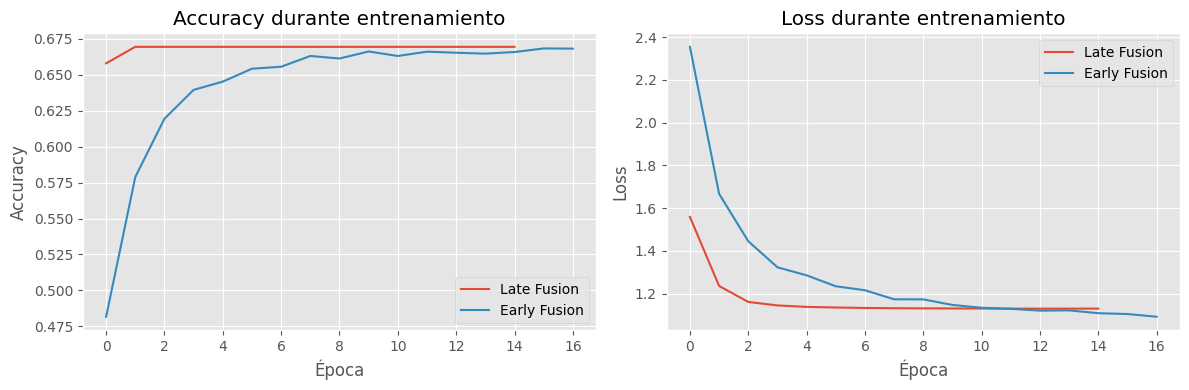

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Encode string labels into integers
label_encoder = LabelEncoder()
y_train_num = label_encoder.fit_transform(y_train)
y_val_num = label_encoder.transform(y_val)

num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train_num, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_num, num_classes=num_classes)

# 4. Crear y compilar modelos
model_late = model_late_fusion

# Compilar modelos
for model in [model_late, model_early]:
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# 6. Entrenamiento y evaluación
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train late fusion
# Ensure the input shapes are correct
print(f"Shape of X_train_reshaped: {X_train_reshaped.shape}")
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of X_val_processed: {X_val_processed.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val_encoded: {y_val_encoded.shape}")

# 2. Ajustar los tamaños para que coincidan
min_samples_train = min(x_train.shape[0], X_train_reshaped.shape[0])
min_samples_val = min(x_val.shape[0], X_val_reshaped.shape[0])

# 3. Recortar todos los conjuntos al mismo tamaño
x_train_matched = x_train[:min_samples_train].astype(np.float32)  # Datos tabulares
X_train_reshaped_matched = X_train_reshaped[:min_samples_train].astype(np.float32)  # Imágenes
y_train_encoded_matched = y_train_encoded[:min_samples_train]  # Etiquetas

x_val_matched = x_val[:min_samples_val].astype(np.float32)
X_val_reshaped_matched = X_val_reshaped[:min_samples_val].astype(np.float32)
y_val_encoded_matched = y_val_encoded[:min_samples_val]

# Train late fusion
history_late = model_late.fit(
    [x_train_matched, X_train_reshaped_matched],  # Asegurarnos de usar los datos matched
    y_train_encoded_matched,
    validation_data=(
        [x_val_matched, X_val_reshaped_matched],
        y_val_encoded_matched
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Train early fusion
history_early = model_early.fit(
    [x_train_matched, X_train_reshaped_matched],
    y_train_encoded_matched,
    validation_data=(
        [x_val_matched, X_val_reshaped_matched],
        y_val_encoded_matched
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Preparar datos de test
min_test_samples = min(X_scaled.shape[0], X_test_reshaped.shape[0])
x_test_matched = X_scaled[:min_test_samples].astype(np.float32)
X_test_reshaped_matched = X_test_reshaped[:min_test_samples].astype(np.float32)
Y_test_matched = Y_test[:min_test_samples]


# 8. Comparar resultados
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_late.history['accuracy'], label='Late Fusion')
plt.plot(history_early.history['accuracy'], label='Early Fusion')
plt.title('Accuracy durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_late.history['loss'], label='Late Fusion')
plt.plot(history_early.history['loss'], label='Early Fusion')
plt.title('Loss durante entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Resultados para Late Fusion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00       664
           5       0.01      1.00      0.03        13
           6       0.00      0.00      0.00       113

    accuracy                           0.01      1002
   macro avg       0.00      0.14      0.00      1002
weighted avg       0.00      0.01      0.00      1002


Resultados para Late Fusion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00     

c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


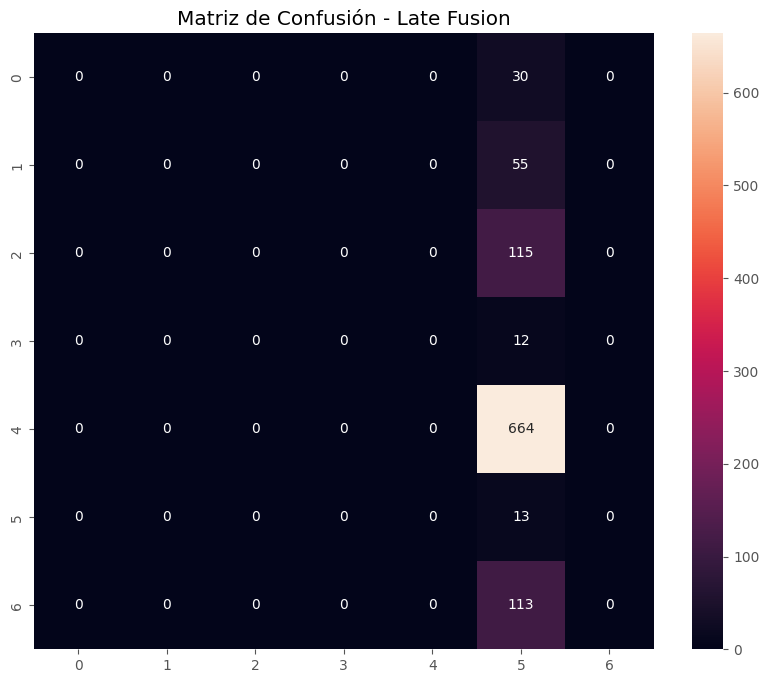

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Resultados para Early Fusion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00       664
           5       0.01      1.00      0.03        13
           6       0.00      0.00      0.00       113

    accuracy                           0.01      1002
   macro avg       0.00      0.14      0.00      1002
weighted avg       0.00      0.01      0.00      1002


Resultados para Early Fusion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00   

c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


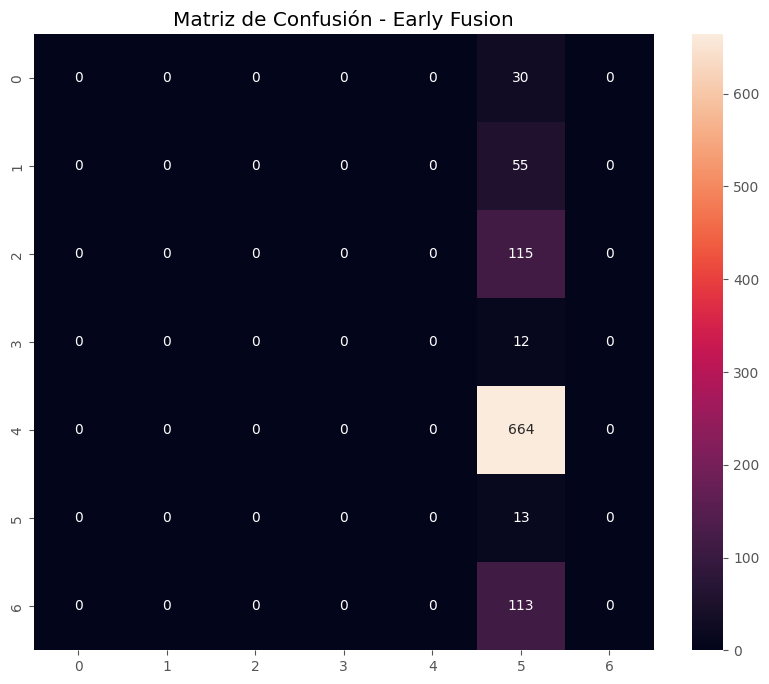

In [26]:
# 7. Evaluar modelos en test
def evaluate_model(model, X_tab_test, X_img_test, y_test, model_name):
    # 1. Primero asegurar que tenemos el mismo número de muestras
    min_samples = min(X_tab_test.shape[0], X_img_test.shape[0])
    
    # 2. Recortar los datos al mismo tamaño
    X_tab_test = X_tab_test[:min_samples].astype(np.float32)
    X_img_test = X_img_test[:min_samples].astype(np.float32)
    y_test = y_test[:min_samples]
    
    # 3. Convertir etiquetas a one-hot encoding si no lo están
    if len(y_test.shape) == 1:
        y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))
    
    # 4. Realizar predicciones
    y_pred = model.predict([X_tab_test, X_img_test])
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # 5. Métricas
    print(f"\nResultados para {model_name}:")
    print(classification_report(y_test_classes, y_pred_classes))
    
    # 6. Matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

# Modificar las llamadas a evaluate_model
evaluate_model(model_late, X_scaled, X_test_reshaped, Y_test, "Late Fusion")  # Cambiar orden de inputs
evaluate_model(model_early, X_scaled, X_test_reshaped, Y_test, "Early Fusion")  # Cambiar orden de inputs


=== Evaluación Modelo Tabular ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.17      0.13      0.15       115
           3       0.00      0.00      0.00        12
           4       0.62      0.02      0.05       664
           5       0.01      0.92      0.03        13
           6       0.00      0.00      0.00       113

    accuracy                           0.04      1002
   macro avg       0.11      0.15      0.03      1002
weighted avg       0.43      0.04      0.05      1002


=== Evaluación Modelo CNN (Imágenes) ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.35      0.37      0.36        30
           1       0.43      0.53      0.48        55
           2       0.50      0.42      0.45       115
           3       0.00      

c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packag

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        12
           4       0.00      0.00      0.00       664
           5       0.01      1.00      0.03        13
           6       0.00      0.00      0.00       113

    accuracy                           0.01      1002
   macro avg       0.00      0.14      0.00      1002
weighted avg       0.00      0.01      0.00      1002


=== Evaluación Modelo Early Fusion ===
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        55
           2       0.00      0.00      0.00       115
           3       0.00      0.00      0.00        12
           4  

c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packag

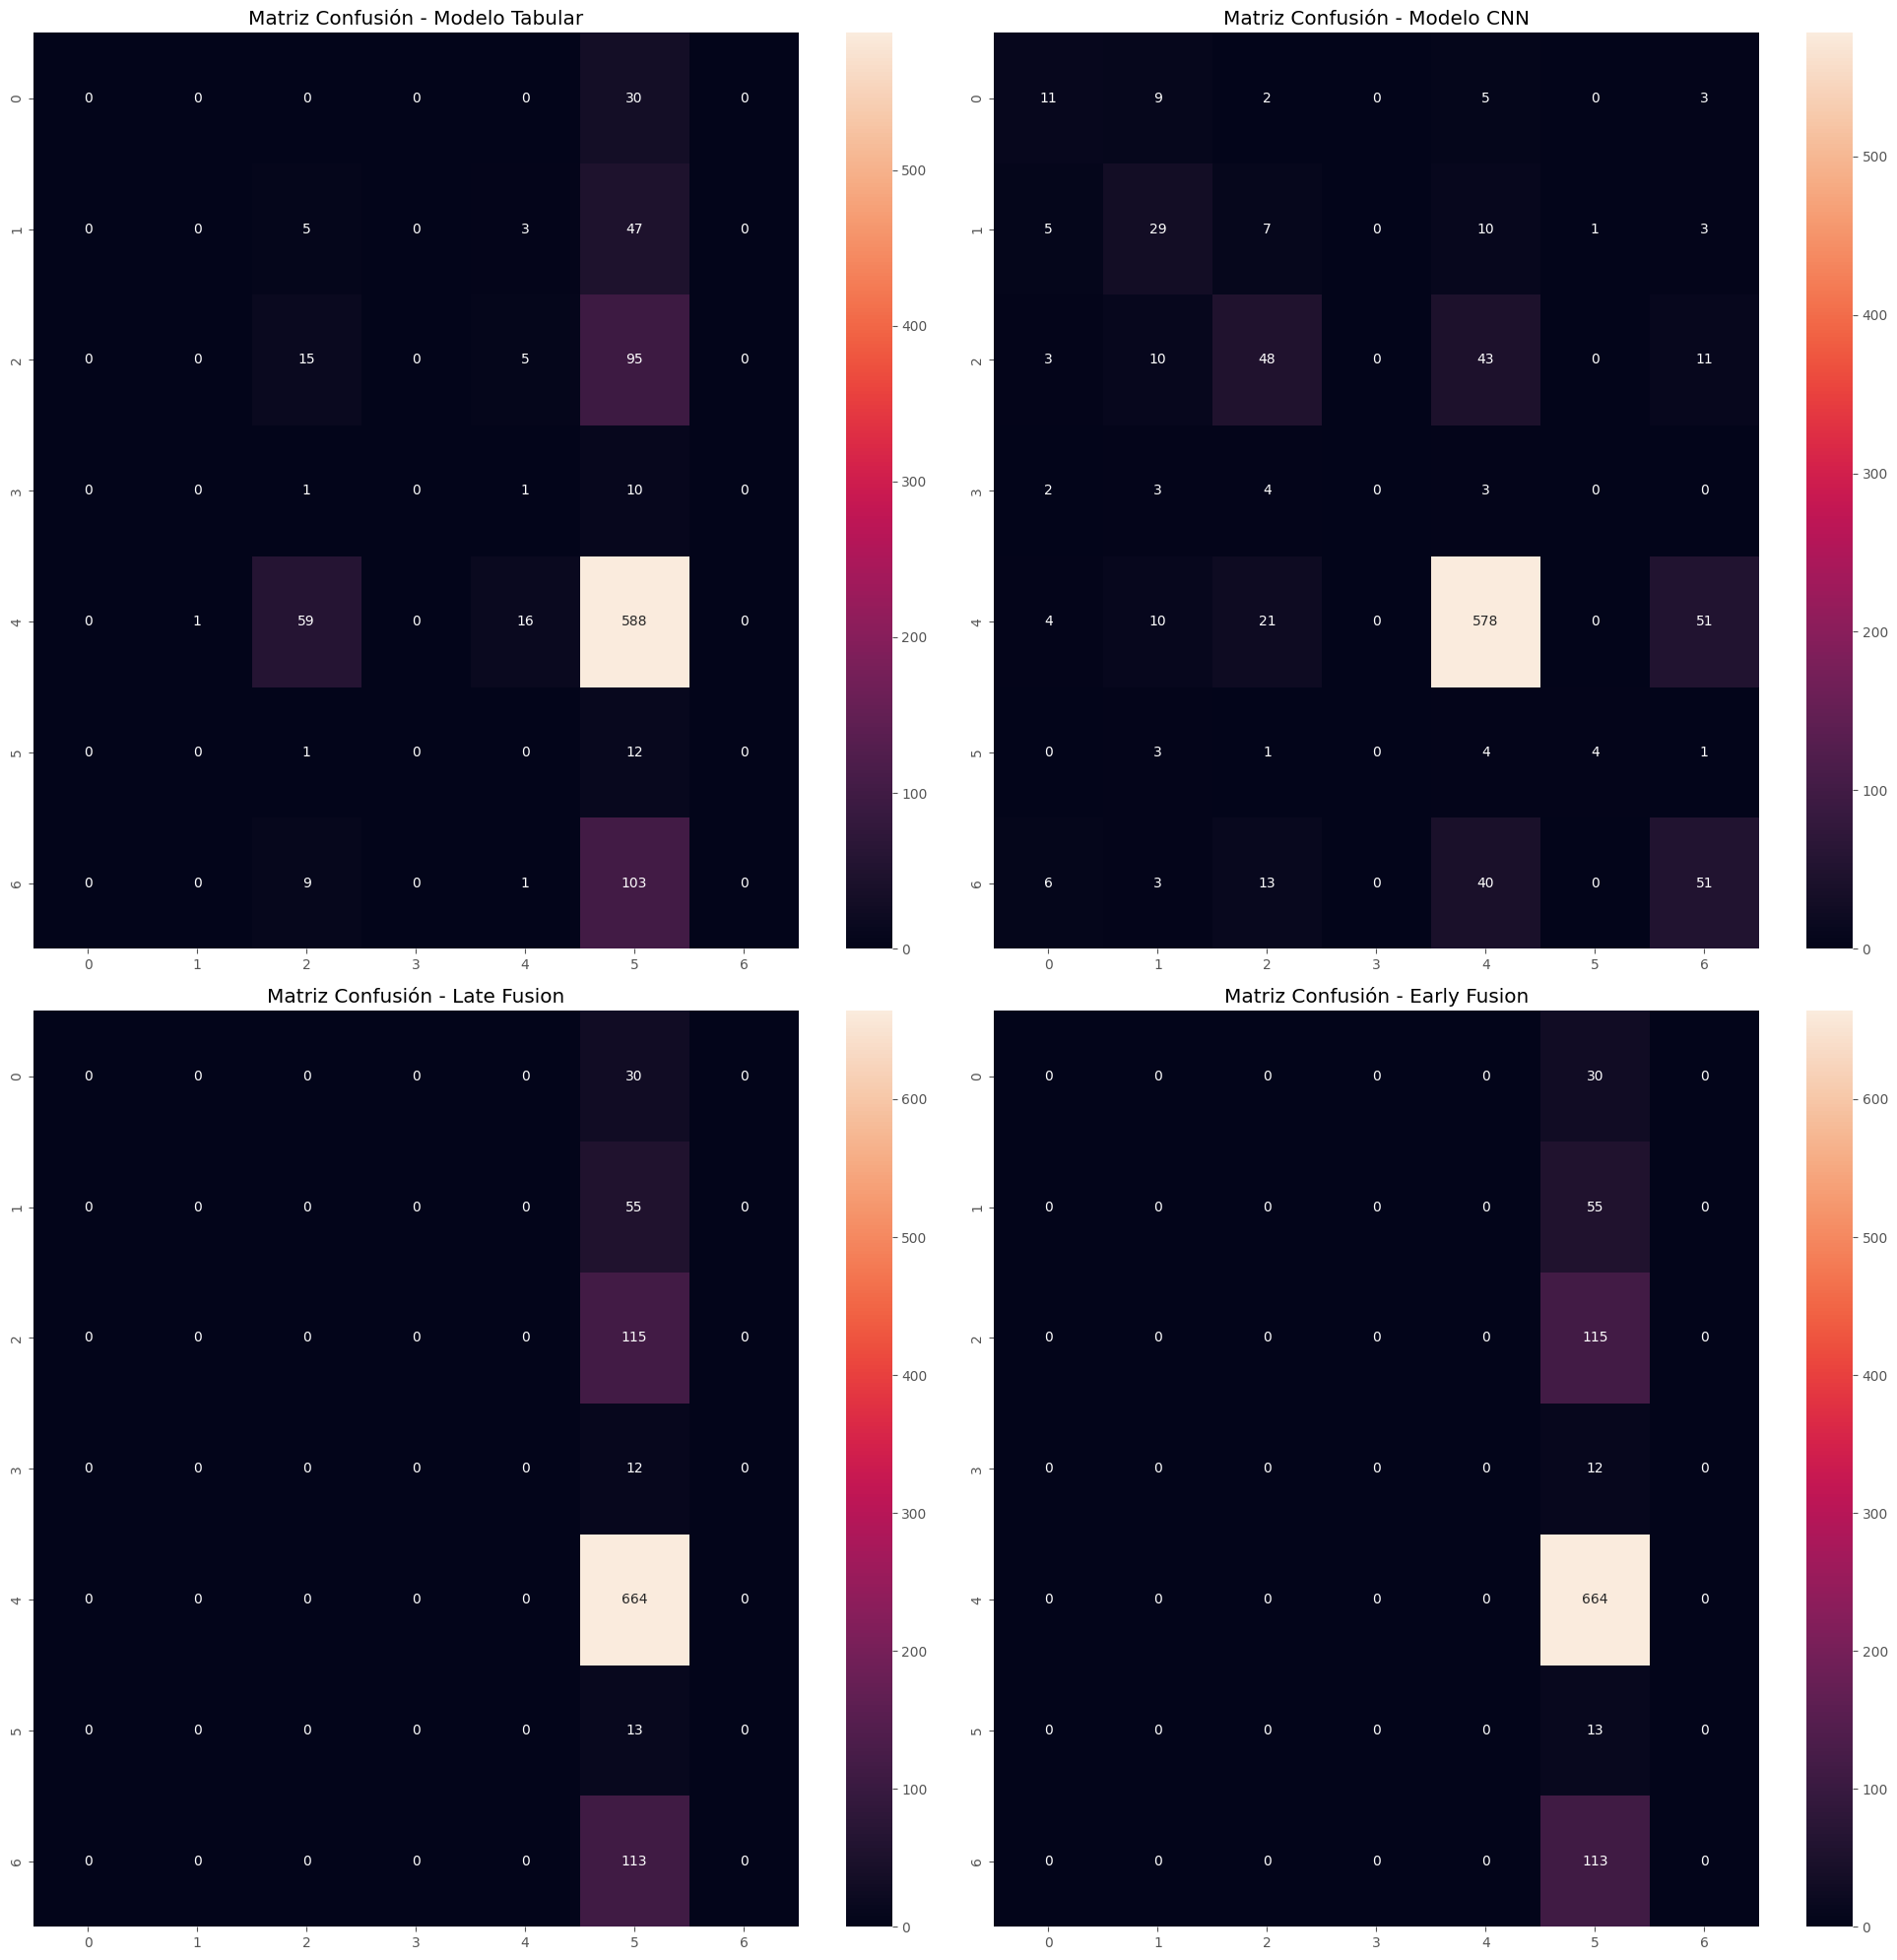


Comparación de modelos:
          Model  Accuracy  Precision    Recall  F1-Score
0       Tabular  0.042914   0.427104  0.042914  0.047875
1           CNN  0.719561   0.710875  0.719561  0.712956
2   Late Fusion  0.012974   0.000168  0.012974  0.000332
3  Early Fusion  0.012974   0.000168  0.012974  0.000332
Error en la evaluación: name 'models' is not defined


c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\pinokio\bin\miniconda\lib\site-packag

<Figure size 1200x600 with 0 Axes>

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_all_models(model_tabular, model_img, model_late, model_early, X_test_tab, X_test_img, y_test):
    """
    Evalúa todos los modelos sobre el conjunto de test
    """
    min_samples = min(X_test_tab.shape[0], X_test_img.shape[0], len(y_test))
    X_test_tab = X_test_tab[:min_samples]
    X_test_img = X_test_img[:min_samples]
    y_test = y_test[:min_samples]
    y_test_onehot = to_categorical(y_test, num_classes=len(np.unique(y_test)))
    
    # 1. Evaluar modelo tabular
    print("\n=== Evaluación Modelo Tabular ===")
    y_pred_tab = model_tabular.predict(X_test_tab)
    print(classification_report(y_test, np.argmax(y_pred_tab, axis=1)))
    
    # 2. Evaluar modelo de imágenes
    print("\n=== Evaluación Modelo CNN (Imágenes) ===")
    y_pred_img = model_img.predict(X_test_img)
    print(classification_report(y_test, np.argmax(y_pred_img, axis=1)))
    
    # 3. Evaluar modelo late fusion
    print("\n=== Evaluación Modelo Late Fusion ===")
    y_pred_late = model_late.predict([X_test_tab, X_test_img])
    print(classification_report(y_test, np.argmax(y_pred_late, axis=1)))
    
    # 4. Evaluar modelo early fusion
    print("\n=== Evaluación Modelo Early Fusion ===")
    y_pred_early = model_early.predict([X_test_tab, X_test_img])
    print(classification_report(y_test, np.argmax(y_pred_early, axis=1)))
    
    # Visualizar matrices de confusión
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    # Matriz de confusión para modelo tabular
    sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred_tab, axis=1)), 
                annot=True, fmt='d', ax=axes[0,0])
    axes[0,0].set_title('Matriz Confusión - Modelo Tabular')
    
    # Matriz de confusión para modelo CNN
    sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred_img, axis=1)), 
                annot=True, fmt='d', ax=axes[0,1])
    axes[0,1].set_title('Matriz Confusión - Modelo CNN')
    
    # Matriz de confusión para late fusion
    sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred_late, axis=1)), 
                annot=True, fmt='d', ax=axes[1,0])
    axes[1,0].set_title('Matriz Confusión - Late Fusion')
    
    # Matriz de confusión para early fusion
    sns.heatmap(confusion_matrix(y_test, np.argmax(y_pred_early, axis=1)), 
                annot=True, fmt='d', ax=axes[1,1])
    axes[1,1].set_title('Matriz Confusión - Early Fusion')
    
    plt.tight_layout()
    plt.show()
    
    # Comparar métricas
    models = ['Tabular', 'CNN', 'Late Fusion', 'Early Fusion']
    predictions = [y_pred_tab, y_pred_img, y_pred_late, y_pred_early]
    
    metrics_comparison = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': []
    }
    
    for model_name, pred in zip(models, predictions):
        pred_classes = np.argmax(pred, axis=1)
        metrics_comparison['Model'].append(model_name)
        metrics_comparison['Accuracy'].append(accuracy_score(y_test, pred_classes))
        metrics_comparison['Precision'].append(precision_score(y_test, pred_classes, average='weighted'))
        metrics_comparison['Recall'].append(recall_score(y_test, pred_classes, average='weighted'))
        metrics_comparison['F1-Score'].append(f1_score(y_test, pred_classes, average='weighted'))
    
    return pd.DataFrame(metrics_comparison)

# Preparar datos de test
min_test_samples = min(X_scaled.shape[0], X_test_reshaped.shape[0])

# Recortar todos los conjuntos al mismo tamaño
X_test_tab = X_scaled[:min_test_samples].astype(np.float32)
X_test_img = X_test_reshaped[:min_test_samples].astype(np.float32)
Y_test_final = Y_test[:min_test_samples]

# Ejecutar evaluación con manejo de errores
try:
    results_df = evaluate_all_models(
        model_tabular=model_tabular,
        model_img=model_img,
        model_late=model_late,
        model_early=model_early,
        X_test_tab=X_test_tab,
        X_test_img=X_test_img,
        y_test=Y_test_final
    )
    # Mostrar resultados comparativos
    print("\nComparación de modelos:")
    print(results_df)

    # Visualizar comparación de métricas
    plt.figure(figsize=(12, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(models))
    width = 0.2

    for i, metric in enumerate(metrics):
        plt.bar(x + i*width, results_df[metric], width, label=metric)

    plt.xlabel('Modelos')
    plt.ylabel('Score')
    plt.title('Comparación de Métricas por Modelo')
    plt.xticks(x + width*1.5, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error en la evaluación: {str(e)}")


# Interpretabilidad

In [ ]:
import lime
from lime import lime_image, lime_tabular

def interpret_with_lime(model, X_instance, feature_names, class_names):
    # Asegurarse de que X_train y feature_names tienen las mismas dimensiones
    if X_train.shape[1] != len(feature_names):
        raise ValueError(f"Número de características ({X_train.shape[1]}) no coincide con la longitud de feature_names ({len(feature_names)})")
    
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification',
        discretize_continuous=True
    )
    
    # Función de predicción que devuelve probabilidades
    def predict_fn(x):
        return model.predict(x)
    
    explanation = explainer.explain_instance(
        X_instance, 
        predict_fn,
        num_features=len(feature_names)
    )
    
    explanation.show_in_notebook()
    return explanation

# Obtener los nombres de características correctamente
feature_names = hamData_encoded.drop(['dx','image_id','lesion_id','dx_type'], axis=1).columns.tolist()
print("\nCaracterísticas seleccionadas:", feature_names)

class_names = hamData['dx'].unique().tolist()

X = hamData_encoded.drop(['dx','image_id','lesion_id','dx_type'], axis=1).values
y = hamData_encoded['dx'].values

# 4. Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Escalar los datos
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Verificar las dimensiones antes de llamar a la función
print(f"Número de características en X_train: {X_train.shape[1]}")
print(f"Número de nombres de características: {len(feature_names)}")

# Llamar a la función
interpret_with_lime(model_tabular, X_val_scaled[0], feature_names, class_names)


Características seleccionadas: ['age', 'sex_male', 'sex_unknown', 'localization_acral', 'localization_back', 'localization_chest', 'localization_ear', 'localization_face', 'localization_foot', 'localization_genital', 'localization_hand', 'localization_lower extremity', 'localization_neck', 'localization_scalp', 'localization_trunk', 'localization_unknown', 'localization_upper extremity']
Número de características en X_train: 17
Número de nombres de características: 17
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


  2%|▏         | 20/1000 [00:00<00:05, 192.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  4%|▍         | 40/1000 [00:00<00:05, 184.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  6%|▌         | 60/1000 [00:00<00:04, 188.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  8%|▊         | 80/1000 [00:00<00:04, 186.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 10%|█         | 100/1000 [00:00<00:05, 179.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 12%|█▏        | 120/1000 [00:00<00:04, 180.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 14%|█▍        | 140/1000 [00:00<00:04, 180.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 16%|█▌        | 160/1000 [00:00<00:04, 183.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 18%|█▊        | 180/1000 [00:00<00:04, 183.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|██        | 200/1000 [00:01<00:04, 183.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|██▏       | 220/1000 [00:01<00:04, 186.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 24%|██▍       | 240/1000 [00:01<00:04, 187.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|██▌       | 260/1000 [00:01<00:03, 185.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 28%|██▊       | 280/1000 [00:01<00:03, 186.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 30%|███       | 300/1000 [00:01<00:03, 184.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███▏      | 320/1000 [00:01<00:03, 183.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 34%|███▍      | 340/1000 [00:01<00:03, 187.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 36%|███▌      | 360/1000 [00:01<00:03, 190.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|███▊      | 380/1000 [00:02<00:03, 187.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 40%|████      | 400/1000 [00:02<00:03, 186.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████▏     | 420/1000 [00:02<00:03, 187.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|████▍     | 440/1000 [00:02<00:03, 185.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 460/1000 [00:02<00:02, 180.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 48%|████▊     | 480/1000 [00:02<00:02, 179.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 50%|█████     | 500/1000 [00:02<00:02, 179.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 52%|█████▏    | 520/1000 [00:02<00:02, 178.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 54%|█████▍    | 540/1000 [00:02<00:02, 178.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|█████▌    | 560/1000 [00:03<00:02, 179.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|█████▊    | 580/1000 [00:03<00:02, 176.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 60%|██████    | 600/1000 [00:03<00:02, 173.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|██████▏   | 620/1000 [00:03<00:02, 175.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████▌   | 650/1000 [00:03<00:01, 182.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 67%|██████▋   | 670/1000 [00:03<00:01, 182.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 69%|██████▉   | 690/1000 [00:03<00:01, 181.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 71%|███████   | 710/1000 [00:03<00:01, 179.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████▎  | 730/1000 [00:03<00:01, 180.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|███████▌  | 750/1000 [00:04<00:01, 182.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 77%|███████▋  | 770/1000 [00:04<00:01, 182.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|███████▉  | 790/1000 [00:04<00:01, 186.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|████████  | 810/1000 [00:04<00:01, 187.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████▎ | 830/1000 [00:04<00:00, 188.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 85%|████████▌ | 850/1000 [00:04<00:00, 188.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████▊ | 880/1000 [00:04<00:00, 193.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|█████████ | 900/1000 [00:04<00:00, 193.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████▏| 920/1000 [00:04<00:00, 192.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|█████████▍| 940/1000 [00:05<00:00, 192.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████▌| 960/1000 [00:05<00:00, 190.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|█████████▊| 980/1000 [00:05<00:00, 188.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 1000/1000 [00:05<00:00, 184.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2159515973911703..2.3720155086104797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2159515973911703..2.3720155086104797].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


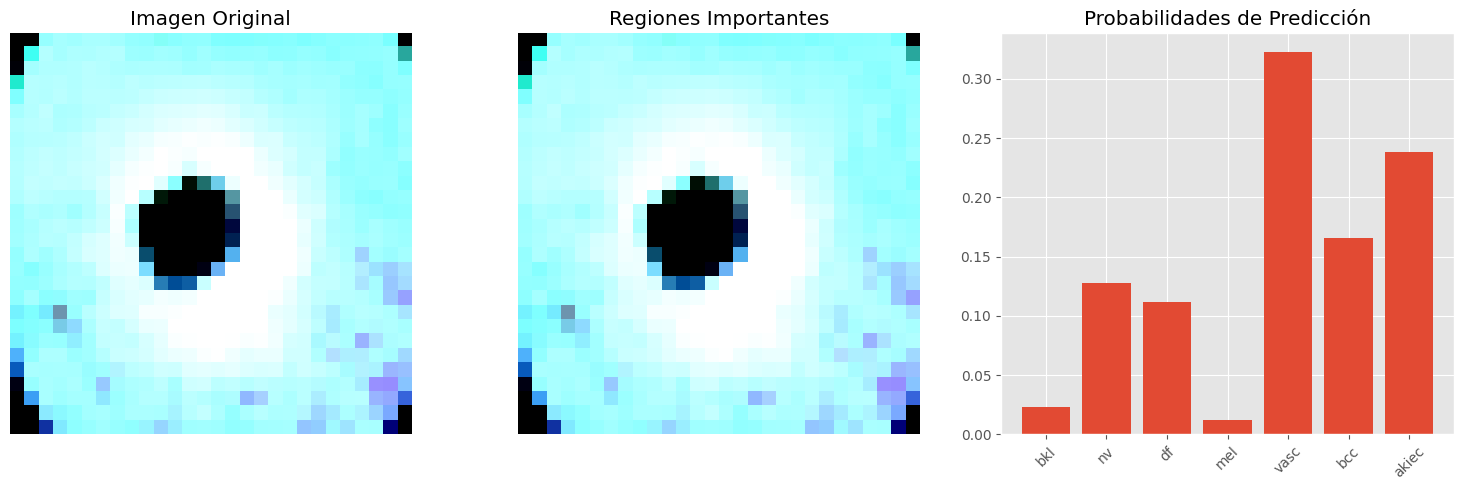

In [ ]:
from skimage.segmentation import mark_boundaries

def interpret_with_lime_images(model, image, class_names):
    # Crear el explicador para imágenes
    explainer = lime_image.LimeImageExplainer()
    
    # Función de predicción que devuelve probabilidades
    def predict_fn(images):
        # Asegurarse de que las imágenes están en el formato correcto
        images = images.copy()
        return model.predict(images)
    
    # Generar la explicación
    explanation = explainer.explain_instance(
        image,  # La imagen a explicar
        predict_fn,  # Función de predicción
        top_labels=3,  # Número de clases a explicar
        hide_color=0,  # Color para ocultar píxeles
        num_samples=1000  # Número de muestras para la explicación
    )
    
    # Visualizar los resultados
    plt.figure(figsize=(15,5))
    
    # Imagen original
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Imagen Original')
    plt.axis('off')
    
    # Obtener la máscara para la clase predicha
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=True
    )
    
    # Visualizar las regiones importantes
    plt.subplot(132)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Regiones Importantes')
    plt.axis('off')
    
    # Probabilidades de predicción
    probs = predict_fn(image[np.newaxis, ...])[0]
    plt.subplot(133)
    plt.bar(range(len(class_names)), probs)
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.title('Probabilidades de Predicción')
    
    plt.tight_layout()
    plt.show()
    
    return explanation

# Ejemplo de uso
# Seleccionar una imagen de validación
image_to_explain = X_val_reshaped[0]

# Interpretar la predicción
explanation = interpret_with_lime_images(
    model=model_img,
    image=image_to_explain,
    class_names=class_names
)

In [ ]:
! pip install shap

c:\pinokio\bin\miniconda\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_591
Received: inputs=['Tensor(shape=(3, 32, 32, 3))']
  warnings.warn(msg)
c:\pinokio\bin\miniconda\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_591
Received: inputs=['Tensor(shape=(50, 32, 32, 3))']
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.2159517..2.2493484].
C:\Users\kage-\AppData\Local\Temp\ipykernel_13792\3752533183.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


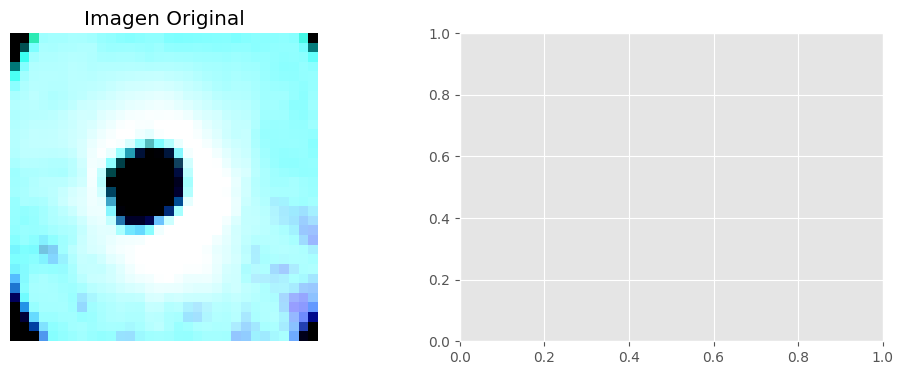

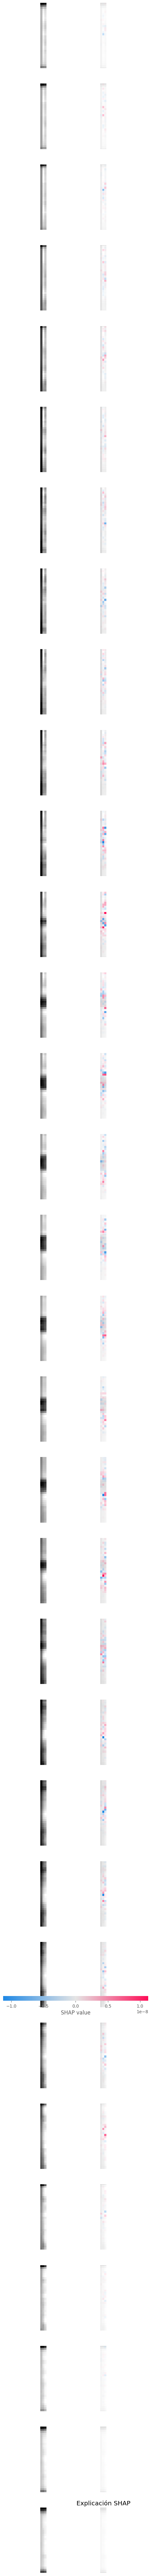

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8134775..2.3476396].


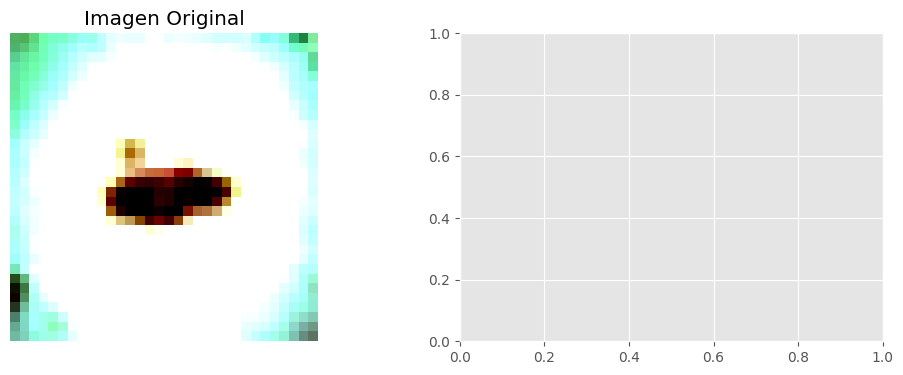

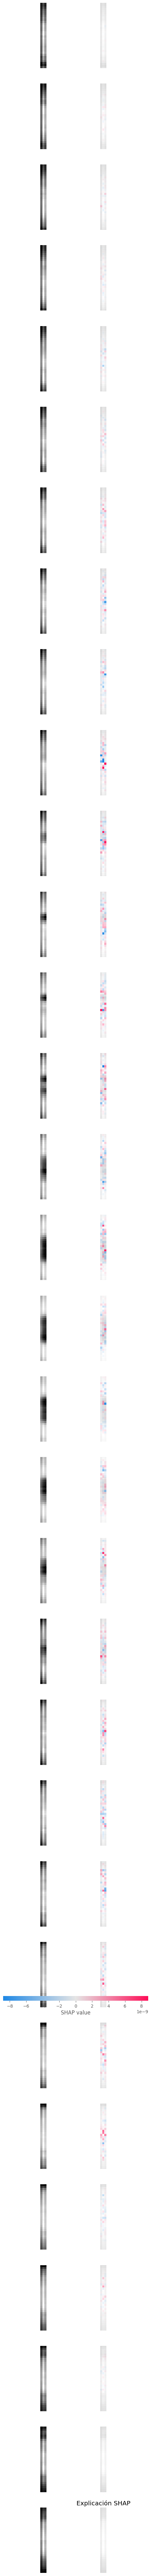

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9399588..1.0934725].


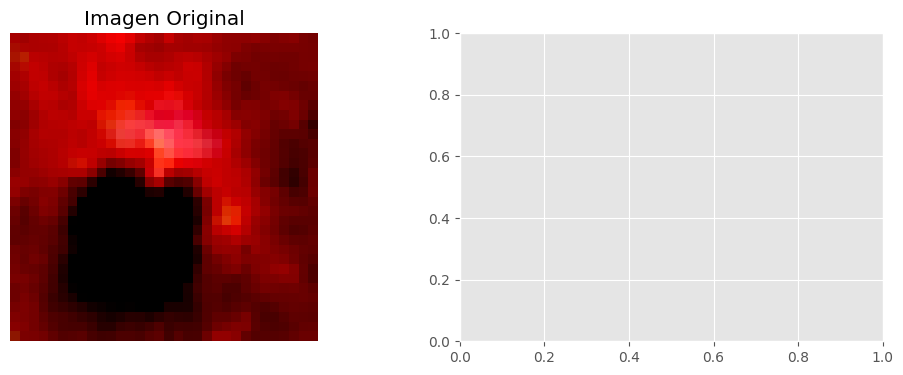

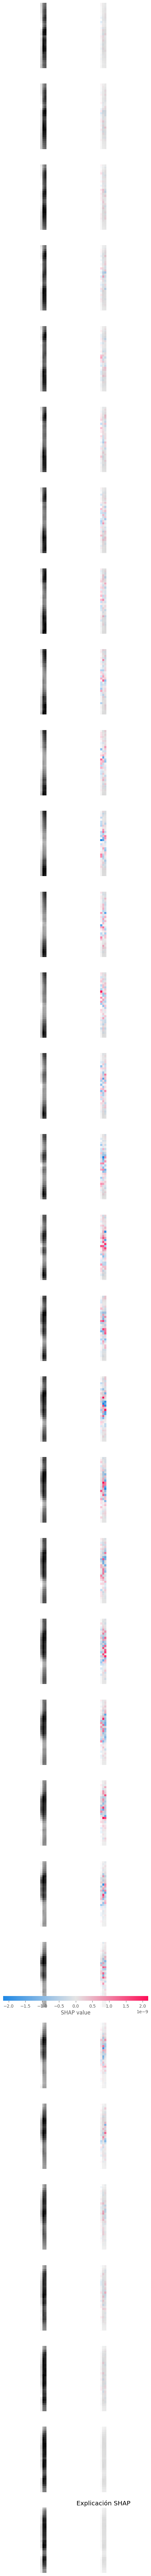

In [ ]:
import shap
import tensorflow as tf
from tensorflow.keras.preprocessing.image import smart_resize

# Habilitar comportamiento numpy para tensores
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Redimensionar las imágenes a 32x32
X_train_resized = np.array([smart_resize(img, (32, 32)) for img in X_train_reshaped])
X_val_resized = np.array([smart_resize(img, (32, 32)) for img in X_val_reshaped])

# Crear un explainer para el modelo de imágenes
background = X_train_resized[:100]  # Usar 100 imágenes como background
explainer = shap.GradientExplainer(model_img, background)

# Seleccionar algunas imágenes para explicar
num_images = 3
images_to_explain = X_val_resized[:num_images]

# Calcular los valores de Shapley
shap_values = explainer.shap_values(images_to_explain)

# Visualizar los valores de Shapley para cada imagen
for i in range(num_images):
    plt.figure(figsize=(12, 4))
    
    # Mostrar la imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(images_to_explain[i])
    plt.title('Imagen Original')
    plt.axis('off')
    
    # Mostrar la explicación SHAP
    plt.subplot(1, 2, 2)
    shap.image_plot(shap_values[i], images_to_explain[i], show=False)
    plt.title('Explicación SHAP')
    
    plt.tight_layout()
    plt.show()